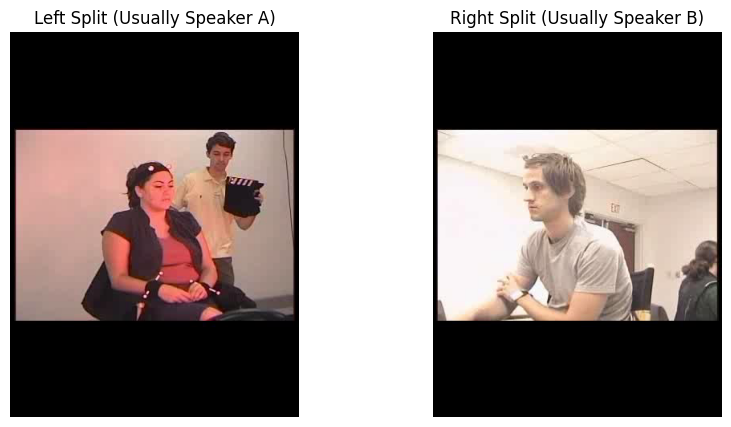

Original Resolution: 720x480
Split Resolution: 360x480


In [2]:
import cv2
import matplotlib.pyplot as plt
import os

# 1. Define the CORRECT path (removing '._')
# Adjust this base path to match where your folder actually is
video_path = "IEMOCAP_full_release/Session1/dialog/avi/DivX/Ses01F_impro02.avi"

# 2. Check if file exists
if not os.path.exists(video_path):
    print(f"Error: File not found at {video_path}")
    print("Check if you are pointing to the '._' file by mistake!")
else:
    # 3. Load Video
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        # Convert BGR (OpenCV) to RGB (Matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 4. Get Dimensions
        height, width, _ = frame_rgb.shape
        midpoint = width // 2
        
        # 5. Split the Frame (Numpy Slicing)
        # Left ROI: 0 to midpoint
        left_speaker = frame_rgb[:, 0:midpoint]
        
        # Right ROI: midpoint to end
        right_speaker = frame_rgb[:, midpoint:width]

        # 6. Display Side-by-Side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        axes[0].imshow(left_speaker)
        axes[0].set_title("Left Split (Usually Speaker A)")
        axes[0].axis('off')
        
        axes[1].imshow(right_speaker)
        axes[1].set_title("Right Split (Usually Speaker B)")
        axes[1].axis('off')
        
        plt.show()
        
        print(f"Original Resolution: {width}x{height}")
        print(f"Split Resolution: {midpoint}x{height}")
    else:
        print("Error: Could not read frame from video.")

For Verifying if the left person's gender is indicated by the the naming convention

In [10]:
# import glob

# # Directory containing the videos
# video_dir = "IEMOCAP_full_release/Session5/dialog/avi/DivX/"

# # List all .avi files
# video_files = glob.glob(os.path.join(video_dir, "*.avi"))

# print(f"Found {len(video_files)} video files in {video_dir}")

# for video_path in video_files:
#     filename = os.path.basename(video_path)
    
#     # Determine gender labels based on filename
#     if len(filename) > 5 and filename[5] == 'F':
#         left_label = "Female"
#         right_label = "Male"
#     elif len(filename) > 5 and filename[5] == 'M':
#         left_label = "Male"
#         right_label = "Female"
#     else:
#         left_label = "Unknown"
#         right_label = "Unknown"
    
#     # Load video and get first frame
#     cap = cv2.VideoCapture(video_path)
#     ret, frame = cap.read()
#     cap.release()
    
#     if ret:
#         # Convert BGR to RGB
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
#         # Get dimensions
#         height, width, _ = frame_rgb.shape
#         midpoint = width // 2
        
#         # Split frame
#         left_speaker = frame_rgb[:, :midpoint]
#         right_speaker = frame_rgb[:, midpoint:]
        
#         # Display
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
#         axes[0].imshow(left_speaker)
#         axes[0].set_title(f"Left: {left_label}")
#         axes[0].axis('off')
        
#         axes[1].imshow(right_speaker)
#         axes[1].set_title(f"Right: {right_label}")
#         axes[1].axis('off')
        
#         plt.show()
        
#         print(f"Video: {filename} - Original Resolution: {width}x{height}, Split: {midpoint}x{height}")
#     else:
#         print(f"Error: Could not read frame from {filename}")

In [3]:
import cv2
import os
from tqdm import tqdm  # specific library for progress bars

# 1. Configuration
source_path = video_path  # Use the same path defined earlier
output_dir = "split_videos"
os.makedirs(output_dir, exist_ok=True)

# Output Paths
out_left_path = os.path.join(output_dir, "left_speaker.avi")
out_right_path = os.path.join(output_dir, "right_speaker.avi")

# 2. Setup Video Capture
cap = cv2.VideoCapture(source_path)

if not cap.isOpened():
    print(f"Error: Could not open video {source_path}")
else:
    # Get Video Properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate new width for split videos
    half_width = width // 2

    print(f"Processing: {total_frames} frames at {fps} FPS")
    print(f"Original Size: {width}x{height} -> Split Size: {half_width}x{height}")

    # 3. Setup Video Writers
    # 'XVID' is a safe codec for .avi files
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out_left = cv2.VideoWriter(out_left_path, fourcc, fps, (half_width, height))
    out_right = cv2.VideoWriter(out_right_path, fourcc, fps, (half_width, height))

    # 4. Processing Loop
    for _ in tqdm(range(total_frames), desc="Splitting Video"):
        ret, frame = cap.read()
        if not ret:
            break
            
        # Split the frame
        left_frame = frame[:, :half_width]
        right_frame = frame[:, half_width:]
        
        # Write to respective files
        out_left.write(left_frame)
        out_right.write(right_frame)

    # 5. Cleanup
    cap.release()
    out_left.release()
    out_right.release()
    print("\nSuccess! Videos saved to:", output_dir)

Processing: 6186 frames at 29.97 FPS
Original Size: 720x480 -> Split Size: 360x480


Splitting Video:   0%|          | 0/6186 [00:00<?, ?it/s]

Splitting Video: 100%|█████████▉| 6185/6186 [00:09<00:00, 661.93it/s]


Success! Videos saved to: split_videos


In [25]:
import re
import os
import csv
import subprocess


def parse_emo_evaluation(txt_path):
    """
    Parse an IEMOCAP EmoEvaluation file and return a list of utterance dicts.
    Each dict: {utterance_id, start, end, emotion}
    Only lines matching the header pattern are parsed.
    """
    pattern = re.compile(r'^\[(\d+\.\d+)\s*-\s*(\d+\.\d+)\]\s+(\S+)\s+(\S+)')
    utterances = []
    with open(txt_path, 'r') as f:
        for line in f:
            m = pattern.match(line.strip())
            if m:
                utterances.append({
                    'start':        float(m.group(1)),
                    'end':          float(m.group(2)),
                    'utterance_id': m.group(3),
                    'emotion':      m.group(4),
                })
    return utterances


def get_speaker_gender_from_utterance(utterance_id):
    """
    Extract speaker gender from utterance id, e.g.
    Ses01F_impro01_F000 -> 'F'
    Ses01F_impro01_M001 -> 'M'
    """
    last = utterance_id.rsplit('_', 1)[-1]   # e.g. 'F000'
    return last[0].upper()                    # 'F' or 'M'


def get_left_speaker_gender_from_filename(video_basename):
    """
    Determine left speaker gender from dialog filename convention.
    Ses01F_... -> left = 'F'
    Ses01M_... -> left = 'M'
    Character at index 5 of the base name.
    """
    name = os.path.basename(video_basename)
    return name[5].upper()  # 'F' or 'M'


def extract_utterance_clip(avi_path, start_time, end_time, crop_side, out_path):
    """
    Use FFmpeg to cut [start_time, end_time] from avi_path,
    crop the video to the left or right half, and extract only
    the matching audio channel (left mic -> left crop, right mic -> right crop).

    IEMOCAP stereo layout:
      FL (front-left)  = left speaker
      FR (front-right) = right speaker

    crop_side: 'left'  -> video crop x=0,    audio channel FL
               'right' -> video crop x=iw/2, audio channel FR
    """
    x_offset    = "0"    if crop_side == 'left' else "iw/2"
    audio_ch    = "c0=FL" if crop_side == 'left' else "c0=FR"

    video_filter = f"crop=iw/2:ih:{x_offset}:0"
    audio_filter = f"pan=mono|{audio_ch}"   # extract single speaker channel -> mono

    cmd = [
        "ffmpeg", "-y",
        "-ss", str(start_time),
        "-to", str(end_time),
        "-i",  avi_path,
        "-vf", video_filter,
        "-af", audio_filter,
        "-c:v", "libxvid",
        "-q:v", "4",           # quality: lower = better (1–31 for XVID)
        "-c:a", "pcm_s16le",   # lossless PCM — preserves audio quality after pan filter
        out_path
    ]

    result = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE)
    if result.returncode != 0:
        raise RuntimeError(
            f"FFmpeg failed for {out_path}:\n{result.stderr.decode(errors='replace')}"
        )


print("Helper functions defined (per-speaker audio channel extraction).")


Helper functions defined (per-speaker audio channel extraction).


In [27]:
# ── Smoke test: first 5 utterances of a single dialog ─────────────────────────
import os

test_avi  = "IEMOCAP_full_release/Session1/dialog/avi/DivX/Ses01F_impro01.avi"
test_emo  = "IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt"
test_dir  = "utterance_clips/tmp/smoke_test_clips"
os.makedirs(test_dir, exist_ok=True)

left_gender = get_left_speaker_gender_from_filename(test_avi)  # 'F'
utterances  = parse_emo_evaluation(test_emo)[:10]               # first 5 only

print(f"Dialog  : {os.path.basename(test_avi)}")
print(f"Left speaker gender: {left_gender}")
print(f"Processing {len(utterances)} utterances...\n")

for utt in utterances:
    utt_id    = utt['utterance_id']
    start     = utt['start']
    end       = utt['end']
    emotion   = utt['emotion']
    spk_gender = get_speaker_gender_from_utterance(utt_id)
    crop_side  = 'left' if spk_gender == left_gender else 'right'
    out_path   = os.path.join(test_dir, f"{utt_id}.avi")

    try:
        extract_utterance_clip(test_avi, start, end, crop_side, out_path)

        # Probe streams
        probe = subprocess.run(
            ["ffprobe", "-v", "error", "-show_streams", "-of", "compact", out_path],
            capture_output=True, text=True
        )
        streams = [l for l in probe.stdout.splitlines() if l.startswith("stream|")]
        has_video = any("codec_type=video" in s for s in streams)
        has_audio = any("codec_type=audio" in s for s in streams)
        size_kb   = os.path.getsize(out_path) / 1024

        status = f"video={'YES' if has_video else 'NO'}  audio={'YES' if has_audio else 'NO'}  size={size_kb:.1f}KB"
        print(f"  [{crop_side:5s}] {utt_id}  [{start:.2f}-{end:.2f}s]  emo={emotion:<4}  {status}")

    except RuntimeError as e:
        print(f"  [ERROR] {utt_id}: {e}")

print(f"\nSmoke test clips saved to: {test_dir}")


Dialog  : Ses01F_impro01.avi
Left speaker gender: F
Processing 10 utterances...

  [left ] Ses01F_impro01_F000  [6.29-8.24s]  emo=neu   video=YES  audio=YES  size=172.8KB
  [left ] Ses01F_impro01_F001  [10.01-11.39s]  emo=neu   video=YES  audio=YES  size=151.7KB
  [left ] Ses01F_impro01_F002  [14.89-18.02s]  emo=neu   video=YES  audio=YES  size=278.7KB
  [left ] Ses01F_impro01_F003  [19.29-20.79s]  emo=xxx   video=YES  audio=YES  size=146.5KB
  [left ] Ses01F_impro01_F004  [21.33-24.74s]  emo=xxx   video=YES  audio=YES  size=338.6KB
  [left ] Ses01F_impro01_F005  [27.46-31.49s]  emo=neu   video=YES  audio=YES  size=455.5KB
  [left ] Ses01F_impro01_F006  [38.97-43.59s]  emo=fru   video=YES  audio=YES  size=522.0KB
  [left ] Ses01F_impro01_F007  [46.58-52.19s]  emo=fru   video=YES  audio=YES  size=639.7KB
  [left ] Ses01F_impro01_F008  [56.16-58.82s]  emo=fru   video=YES  audio=YES  size=271.8KB
  [left ] Ses01F_impro01_F009  [61.87-65.97s]  emo=fru   video=YES  audio=YES  size=398.9KB



In [28]:
from tqdm import tqdm
import glob

# ── Configuration ──────────────────────────────────────────────────────────────
BASE_DIR    = "IEMOCAP_full_release"
OUTPUT_ROOT = "utterance_clips"          # clips saved here, organised by session
SESSIONS    = [f"Session{i}" for i in range(1, 6)]

os.makedirs(OUTPUT_ROOT, exist_ok=True)

total_written  = 0
total_skipped  = 0

# CSV manifest
manifest_path = os.path.join(OUTPUT_ROOT, "manifest.csv")
manifest_rows  = [["utterance_id", "emotion", "speaker_gender", "crop_side", "start", "end", "path"]]

for session in SESSIONS:
    avi_dir = os.path.join(BASE_DIR, session, "dialog", "avi", "DivX")
    emo_dir = os.path.join(BASE_DIR, session, "dialog", "EmoEvaluation")

    # Collect real .avi files only (skip macOS ._* resource forks)
    avi_files = sorted([
        f for f in glob.glob(os.path.join(avi_dir, "*.avi"))
        if not os.path.basename(f).startswith("._")
    ])

    for avi_path in avi_files:
        basename = os.path.splitext(os.path.basename(avi_path))[0]  # e.g. Ses01F_impro01
        emo_path = os.path.join(emo_dir, basename + ".txt")

        if not os.path.exists(emo_path):
            print(f"  [SKIP] No EmoEvaluation file found for {basename}")
            total_skipped += 1
            continue

        # Determine which gender is on the LEFT side of the video
        left_gender = get_left_speaker_gender_from_filename(basename)  # 'F' or 'M'

        # Parse all utterances for this dialog
        utterances = parse_emo_evaluation(emo_path)
        if not utterances:
            print(f"  [SKIP] No utterances parsed from {emo_path}")
            continue

        # Output directory per dialog
        out_dialog_dir = os.path.join(OUTPUT_ROOT, session, basename)
        os.makedirs(out_dialog_dir, exist_ok=True)

        for utt in tqdm(utterances, desc=f"{basename}", leave=False):
            utt_id    = utt['utterance_id']
            emotion   = utt['emotion']
            start     = utt['start']
            end       = utt['end']

            # Determine crop side based on utterance speaker vs left-side gender
            spk_gender = get_speaker_gender_from_utterance(utt_id)   # 'F' or 'M'
            crop_side  = 'left' if spk_gender == left_gender else 'right'

            out_path = os.path.join(out_dialog_dir, f"{utt_id}.avi")

            try:
                extract_utterance_clip(avi_path, start, end, crop_side, out_path)
                manifest_rows.append([utt_id, emotion, spk_gender, crop_side, start, end, out_path])
                total_written += 1
            except RuntimeError as e:
                print(f"  [ERROR] {utt_id}: {e}")

# Write manifest CSV
with open(manifest_path, 'w', newline='') as f:
    csv.writer(f).writerows(manifest_rows)

print(f"\nDone!  Clips written : {total_written}")
print(f"       Dialogs skipped: {total_skipped}")
print(f"       Manifest saved : {manifest_path}")


KeyboardInterrupt: 